In [20]:
from pathlib import Path

import numpy as np
from moviepy.editor import AudioFileClip, VideoClip
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter

ROOT = Path("..")

In [2]:
# ---------- CONFIG ----------
AUDIO_PATH = str(ROOT / "data/sample.mp3")
OUTPUT_PATH = str(ROOT / "output/sample.mp4")
IMG_PATH = str(ROOT / "data/sample.jpg")
FPS = 30
# -----------------------------

In [3]:
def load_audio(path):

    # Load the audio
    audio_clip = AudioFileClip(path)

    # Convert audio to a numpy array (mono)
    # fps here is only for analysis, not video fps
    analysis_fps = 44100

    # Manually collect chunks into a list, then concatenate
    chunks = list(
        audio_clip.iter_chunks(
            fps=analysis_fps,
            quantize=True,  # get int16-ish PCM
            nbytes=2,
            chunksize=1024
        )
    )

    return np.concatenate(chunks, axis=0).astype(np.float32)


def normalize(audio_array):
    # Convert to mono if stereo
    if audio_array.ndim == 2:
        mono = audio_array.mean(axis=1)
    else:
        mono = audio_array

    min = mono.min()
    max = mono.max()
    return (mono - min)/(max - min + 1e-7)

In [ ]:
def viz_audio(audio_path, image_path, video_output, blur=True, wave_color="black"):

    audio_clip = AudioFileClip(audio_path)
    duration = audio_clip.duration

    mono = load_audio(audio_path)
    mono = normalize(mono)

    base_img = Image.open(image_path)
    if blur:
        base_img = base_img.filter(ImageFilter.BLUR)

    height, width = np.array(base_img).shape[0:2]
    dpi = 100

    fig = plt.figure()
    fig = plt.figure(figsize=(width / dpi, height / dpi), dpi=dpi)
    ax = fig.add_axes([0, 0, 1, 1])

    # Function to generate each video frame
    def make_frame(t):

        ax.cla()
        ax.imshow(base_img)
        ax.axis("off")

        idx = int(t/duration*(mono.shape[0]-1))
        wave = mono[:idx+1]
        wave = wave*height/2.
        wave = wave+height/4.

        x = t/duration*width
        t = np.linspace(0, x, len(wave))
        ax.plot(t, wave, color=wave_color)

        # Render the figure
        fig.tight_layout()
        fig.canvas.draw()

        # RGBA buffer as (H, W, 4)
        buf = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
        w, h = fig.canvas.get_width_height()
        frame = buf.reshape(h, w, 4)[..., :3]

        return frame

    # Create video clip
    video_clip = VideoClip(make_frame, duration=duration)
    video_clip = video_clip.set_audio(audio_clip)

    # Export
    video_clip.write_videofile(
        video_output,
        fps=FPS,
        codec="libx264",
        audio_codec="aac"
    )

Moviepy - Building video ../output/sample.mp4.
MoviePy - Writing audio in sampleTEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ../output/sample.mp4



Moviepy - Done !
Moviepy - video ready ../output/sample.mp4


<Figure size 640x480 with 0 Axes>

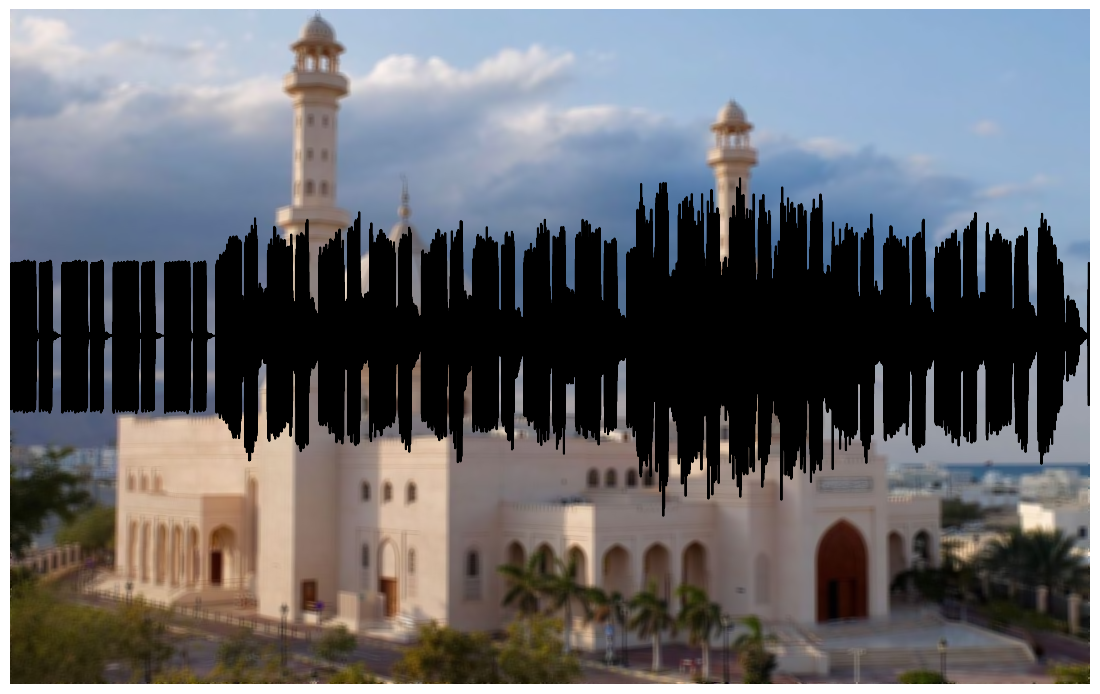

In [22]:
viz_audio(AUDIO_PATH, IMG_PATH, OUTPUT_PATH)